# Invariances

Notebook for measuring and comparing the invariance of neurons in CellEMNet and ImageNet pretrained models. Invariance is calculated by the mean firing rate at a particular augmentation strength.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import os, sys
import numpy as np
import torch
import torch.nn as nn
import torchvision.transforms as tf
from torchvision.models import resnet50
from tqdm import tqdm
from matplotlib import pyplot as plt
from scipy.signal import savgol_filter

In [3]:
from _helpers import *

In [4]:
#define the device that we're using
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#load the cellemnet and imagenet moco pretrained models
cellemnet, cellemnet_norms = load_moco_pretrained(dataset='cellemnet')
imagenet, _ = load_moco_pretrained(dataset='imagenet')

#next we want to remove the fully connected layers 
#(i.e. the last layer), such that the output layer will be 
#the avgpooled results of the resnet's layer4
cellemnet = nn.Sequential(*list(cellemnet.children())[:-1])
imagenet = nn.Sequential(*list(imagenet.children())[:-1])

#move the models to devices and set to eval mode
cellemnet = cellemnet.to(device).eval()
imagenet = imagenet.to(device).eval()

In [5]:
#create transform class to perform initial crop
aug_cellemnet = [
    tf.Grayscale(3),
    tf.Resize(224),
    tf.Grayscale(1),
    tf.ToTensor(),
    tf.Normalize(mean=cellemnet_norms[0], std=cellemnet_norms[1]),
]

#create transform class to perform initial crop
aug_imagenet = [
    tf.Grayscale(3),
    tf.Resize(224),
    tf.ToTensor(),
    tf.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
]

#creat a dataset without any augmentations for now,
#the augmentations will need to be dyanmically changing
dataset = DataFolder('example_data/occlusion/', None)

Found 10 images in example_data/occlusion/


In [6]:
#alright, we need to calibrate our thresholds for neuron
#firing strengths. to do this we pass random noise images through
#each of the NNs and measure responses. we draw thresholds at the top
#1% of responses. we can conclude later on that there's along a 1% chance
#that responses to real images over this threshold are random and not
#selective
cellemnet_responses = []
imagenet_responses = []
for _ in range(1000):
    rand_image = torch.randn((1, 3, 224, 224), dtype=torch.float32).to(device)
    with torch.no_grad():
        #run the image through the models
        cellemnet_responses.append(cellemnet(rand_image[:, :1]).squeeze().detach().cpu().numpy())
        imagenet_responses.append(imagenet(rand_image).squeeze().detach().cpu().numpy())

#stack to form (1000, 2048)
cellemnet_responses = np.stack(cellemnet_responses, axis=1)
imagenet_responses = np.stack(imagenet_responses, axis=1)

#get the 99th percentile of responses to random noise
cellemnet_thr = np.quantile(cellemnet_responses, 0.99, axis=1)
imagenet_thr = np.quantile(imagenet_responses, 0.99, axis=1)

## Rotation

In [10]:
#define the augmentation strengths
#for rotation it's 0-360 degrees
#we'll go in 10 degree increments
strengths = np.linspace(0, 360, num=37)

#define the reference index for the augmentation.
#this is the augmentation strength at which an image
#will be undistorted. for rotation that angle is 0 degrees
#which is the zeroeth entry in strengths
ref_index = 0

#define the list of additive augmentations
#one entry for each strength: the torchvision
#transform expects a range of angles, by giving
#it the same value for minimum and maximum we ensure
#that the result is a deterministic rotation
additive_augs = [tf.RandomRotation((strength, strength)) for strength in strengths]

#where to insert the new augmentations in the augmentation
#order. e.g. for rotation we want to insert the augmentation
#after resizing but before conversion to a torch tensor
#see aug_cellemnet and aug_imagenet
cn_aug_insert_loc = 2
in_aug_insert_loc = 2

#calculate the local trajectories for images in the dataset
cellemnet_trajectories = transform_local_trajectory(cellemnet, dataset, aug_cellemnet, additive_augs, cn_aug_insert_loc)
imagenet_trajectories = transform_local_trajectory(imagenet, dataset, aug_imagenet, additive_augs, in_aug_insert_loc)

In [38]:
#calculate the mean firing rates
cellemnet_mfr = calculate_mean_firing_rates(cellemnet_trajectories, cellemnet_thr, ref_index, 0.9)
imagenet_mfr = calculate_mean_firing_rates(imagenet_trajectories, imagenet_thr, ref_index, 0.9)

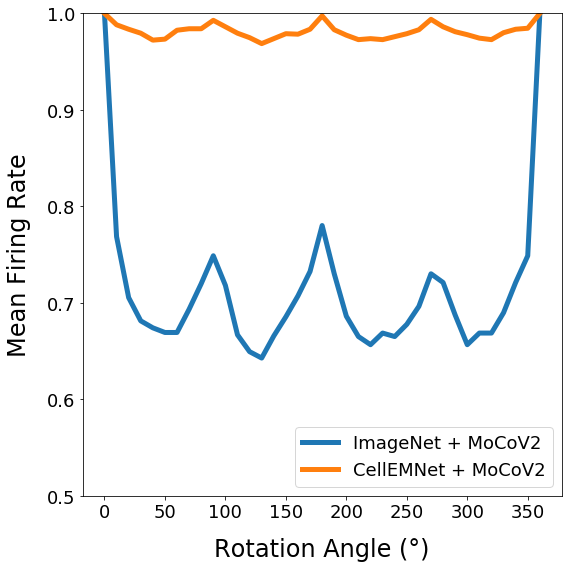

In [52]:
plt.figure(figsize=(8, 8))
plt.plot(strengths, imagenet_mfr, linewidth=5, label='ImageNet + MoCoV2')
plt.plot(strengths, cellemnet_mfr, linewidth=5, label='CellEMNet + MoCoV2')

plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(bottom=0.5, top=1)
plt.xlabel('Rotation Angle (°)', fontsize=24, labelpad=16)
plt.ylabel('Mean Firing Rate', fontsize=24, labelpad=16)
plt.tight_layout()

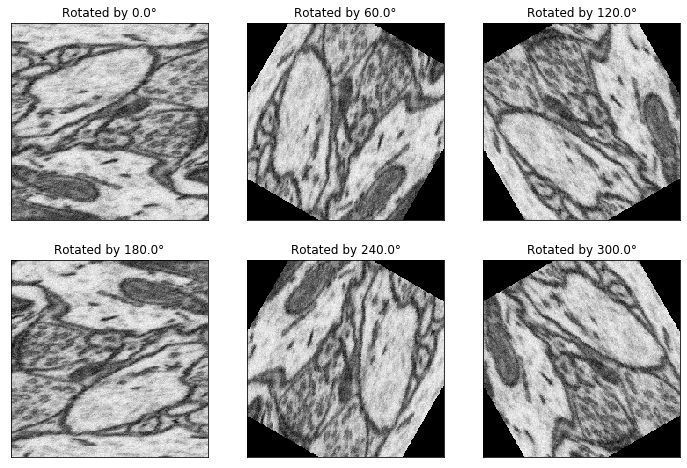

In [50]:
#plot some example images of the augmentation strengths
f, ax = plt.subplots(2, 3, figsize=(12, 8))

step = len(strengths) // 6

titles = []
examples = []
for strength, aug in zip(strengths[::step], additive_augs[::step]):
    augs = aug_cellemnet[:cn_aug_insert_loc] + [aug] + aug_cellemnet[cn_aug_insert_loc:]

    #overwrite the datasets transforms with the composed augmentations
    dataset.tfs = tf.Compose(augs)

    #get the example image by taking the:
    #zeroeth image in dataset; then its first augmented copy; then its first channel
    titles.append(f'Rotated by {strength}°')
    examples.append(dataset[0][0][0]) 
    
c = 0
for y in range(2):
    for x in range(3):
        ax[y, x].set_title(titles[c])
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].imshow(examples[c], cmap='gray')
        c += 1

## Gaussian Blur

In [54]:
#define the augmentation strengths
#blur can't be exactly zero, so we'll
#just use a really small float instead
strengths = np.linspace(1e-15, 5, num=20)

#define the reference index for the augmentation.
ref_index = 0

#define the list of additive augmentations
additive_augs = [GaussianBlur((strength, strength)) for strength in strengths]

#where to insert the new augmentations in the augmentation
cn_aug_insert_loc = 2
in_aug_insert_loc = 2

#calculate the local trajectories for images in the dataset
cellemnet_trajectories = transform_local_trajectory(cellemnet, dataset, aug_cellemnet, additive_augs, cn_aug_insert_loc)
imagenet_trajectories = transform_local_trajectory(imagenet, dataset, aug_imagenet, additive_augs, in_aug_insert_loc)

In [55]:
#calculate the mean firing rates
cellemnet_mfr = calculate_mean_firing_rates(cellemnet_trajectories, cellemnet_thr, ref_index, 0.9)
imagenet_mfr = calculate_mean_firing_rates(imagenet_trajectories, imagenet_thr, ref_index, 0.9)

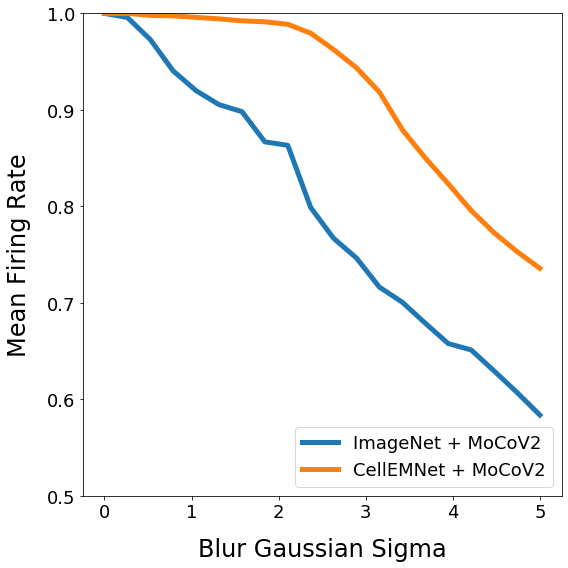

In [56]:
plt.figure(figsize=(8, 8))
plt.plot(strengths, imagenet_mfr, linewidth=5, label='ImageNet + MoCoV2')
plt.plot(strengths, cellemnet_mfr, linewidth=5, label='CellEMNet + MoCoV2')

plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(bottom=0.5, top=1)
plt.xlabel('Blur Gaussian Sigma', fontsize=24, labelpad=16)
plt.ylabel('Mean Firing Rate', fontsize=24, labelpad=16)
plt.tight_layout()

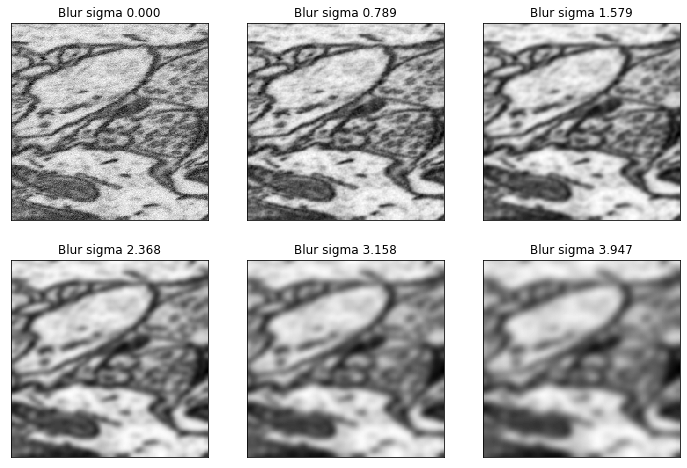

In [60]:
#plot some example images of the augmentation strengths
f, ax = plt.subplots(2, 3, figsize=(12, 8))

step = len(strengths) // 6

titles = []
examples = []
for strength, aug in zip(strengths[::step], additive_augs[::step]):
    augs = aug_cellemnet[:cn_aug_insert_loc] + [aug] + aug_cellemnet[cn_aug_insert_loc:]

    #overwrite the datasets transforms with the composed augmentations
    dataset.tfs = tf.Compose(augs)

    #get the example image by taking the:
    #zeroeth image in dataset; then its first augmented copy; then its first channel
    titles.append(f'Blur sigma {strength:.3f}')
    examples.append(dataset[0][0][0]) 
    
c = 0
for y in range(2):
    for x in range(3):
        ax[y, x].set_title(titles[c])
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].imshow(examples[c], cmap='gray')
        c += 1

## Gaussian Noise

In [65]:
#define the augmentation strengths
#noise can't be exactly zero, so we'll
#just use a really small float instead
#sample points over a log scale
strengths = np.linspace(1e-5, 3e-2, num=20)

#define the reference index for the augmentation.
ref_index = 0

#define the list of additive augmentations
additive_augs = [GaussNoise((strength, strength)) for strength in strengths]

#where to insert the new augmentations in the augmentation
cn_aug_insert_loc = 4
in_aug_insert_loc = 3

#calculate the local trajectories for images in the dataset
cellemnet_trajectories = transform_local_trajectory(cellemnet, dataset, aug_cellemnet, additive_augs, cn_aug_insert_loc)
imagenet_trajectories = transform_local_trajectory(imagenet, dataset, aug_imagenet, additive_augs, in_aug_insert_loc)

In [69]:
#calculate the mean firing rates
cellemnet_mfr = calculate_mean_firing_rates(cellemnet_trajectories, cellemnet_thr, ref_index, 0.9)
imagenet_mfr = calculate_mean_firing_rates(imagenet_trajectories, imagenet_thr, ref_index, 0.9)

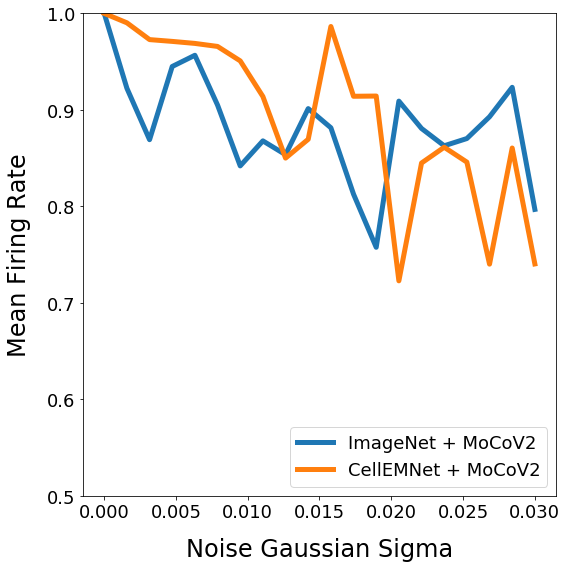

In [70]:
plt.figure(figsize=(8, 8))
plt.plot(strengths, imagenet_mfr, linewidth=5, label='ImageNet + MoCoV2')
plt.plot(strengths, cellemnet_mfr, linewidth=5, label='CellEMNet + MoCoV2')

plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(bottom=0.5, top=1)
plt.xlabel('Noise Gaussian Sigma', fontsize=24, labelpad=16)
plt.ylabel('Mean Firing Rate', fontsize=24, labelpad=16)
plt.tight_layout()

NOTE: The more example images are needed to smoothen out the results.

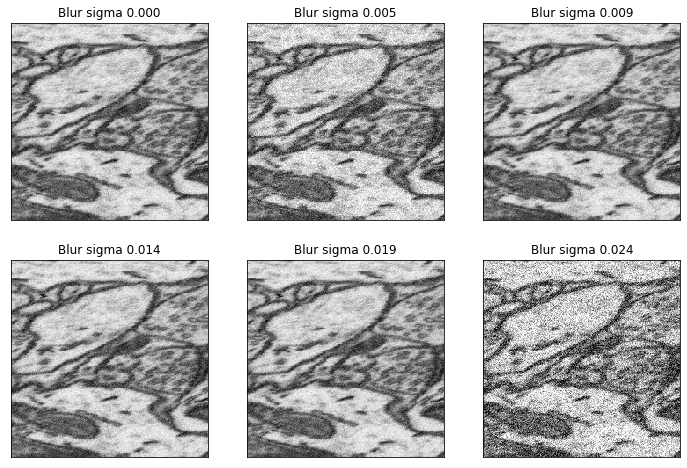

In [68]:
#plot some example images of the augmentation strengths
f, ax = plt.subplots(2, 3, figsize=(12, 8))

step = len(strengths) // 6

titles = []
examples = []
for strength, aug in zip(strengths[::step], additive_augs[::step]):
    augs = aug_cellemnet[:cn_aug_insert_loc] + [aug] + aug_cellemnet[cn_aug_insert_loc:]

    #overwrite the datasets transforms with the composed augmentations
    dataset.tfs = tf.Compose(augs)

    #get the example image by taking the:
    #zeroeth image in dataset; then its first augmented copy; then its first channel
    titles.append(f'Blur sigma {strength:.3f}')
    examples.append(dataset[0][0][0]) 
    
c = 0
for y in range(2):
    for x in range(3):
        ax[y, x].set_title(titles[c])
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].imshow(examples[c], cmap='gray')
        c += 1

## Brightness

In [7]:
#define the augmentation strengths
strengths = np.linspace(0, 2, num=21)

#define the reference index for the augmentation.
#for brightness it's where strengths == 1
ref_index = 10

#define the list of additive augmentations
additive_augs = [tf.ColorJitter(brightness=(strength, strength)) for strength in strengths]

#where to insert the new augmentations in the augmentation
cn_aug_insert_loc = 2
in_aug_insert_loc = 2

#calculate the local trajectories for images in the dataset
cellemnet_trajectories = transform_local_trajectory(cellemnet, dataset, aug_cellemnet, additive_augs, cn_aug_insert_loc)
imagenet_trajectories = transform_local_trajectory(imagenet, dataset, aug_imagenet, additive_augs, in_aug_insert_loc)

In [8]:
#calculate the mean firing rates
cellemnet_mfr = calculate_mean_firing_rates(cellemnet_trajectories, cellemnet_thr, ref_index, 0.9)
imagenet_mfr = calculate_mean_firing_rates(imagenet_trajectories, imagenet_thr, ref_index, 0.9)

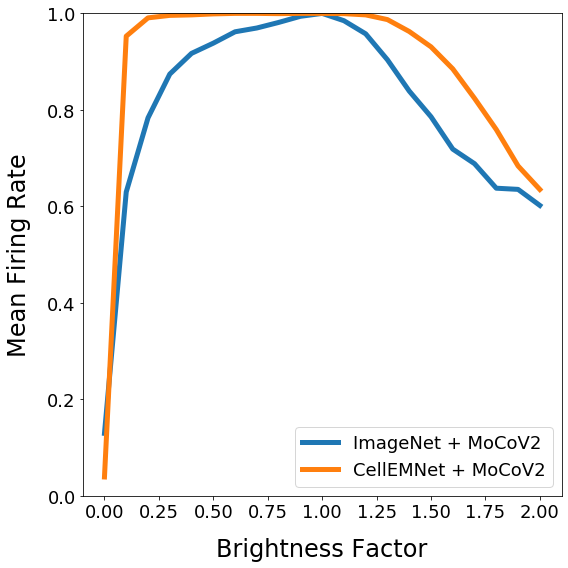

In [9]:
plt.figure(figsize=(8, 8))
plt.plot(strengths, imagenet_mfr, linewidth=5, label='ImageNet + MoCoV2')
plt.plot(strengths, cellemnet_mfr, linewidth=5, label='CellEMNet + MoCoV2')

plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(bottom=0.0, top=1)
plt.xlabel('Brightness Factor', fontsize=24, labelpad=16)
plt.ylabel('Mean Firing Rate', fontsize=24, labelpad=16)
plt.tight_layout()

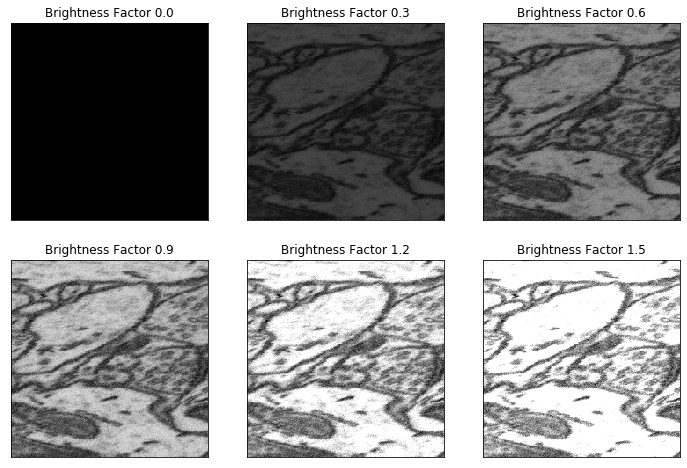

In [84]:
#plot some example images of the augmentation strengths
f, ax = plt.subplots(2, 3, figsize=(12, 8))

step = len(strengths) // 6

titles = []
examples = []
for strength, aug in zip(strengths[::step], additive_augs[::step]):
    augs = aug_cellemnet[:cn_aug_insert_loc] + [aug] + aug_cellemnet[cn_aug_insert_loc:]

    #overwrite the datasets transforms with the composed augmentations
    dataset.tfs = tf.Compose(augs)

    #get the example image by taking the:
    #zeroeth image in dataset; then its first augmented copy; then its first channel
    titles.append(f'Brightness Factor {strength:.1f}')
    examples.append(dataset[0][0][0])
    
#get maximum and minimum pixel values to use
#when plotting (otherwise pyplot rescales everything)
vmin = min([ex.min().item() for ex in examples])
vmax = max([ex.max().item() for ex in examples])
    
c = 0
for y in range(2):
    for x in range(3):
        ax[y, x].set_title(titles[c])
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].imshow(examples[c], cmap='gray', vmin=vmin, vmax=vmax)
        c += 1

## Contrast

In [10]:
#define the augmentation strengths
strengths = np.linspace(0, 2, num=21)

#define the reference index for the augmentation.
#for contrast it's where strengths == 1
ref_index = 10

#define the list of additive augmentations
additive_augs = [tf.ColorJitter(contrast=(strength, strength)) for strength in strengths]

#where to insert the new augmentations in the augmentation
cn_aug_insert_loc = 2
in_aug_insert_loc = 2

#calculate the local trajectories for images in the dataset
cellemnet_trajectories = transform_local_trajectory(cellemnet, dataset, aug_cellemnet, additive_augs, cn_aug_insert_loc)
imagenet_trajectories = transform_local_trajectory(imagenet, dataset, aug_imagenet, additive_augs, in_aug_insert_loc)

In [11]:
#calculate the mean firing rates
cellemnet_mfr = calculate_mean_firing_rates(cellemnet_trajectories, cellemnet_thr, ref_index, 0.9)
imagenet_mfr = calculate_mean_firing_rates(imagenet_trajectories, imagenet_thr, ref_index, 0.9)

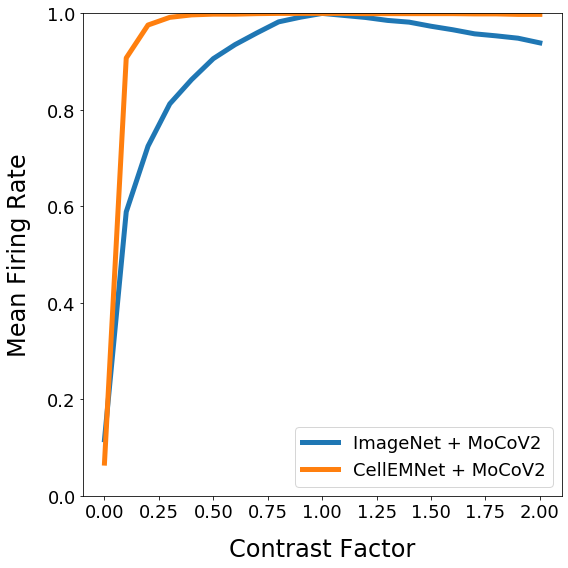

In [12]:
plt.figure(figsize=(8, 8))
plt.plot(strengths, imagenet_mfr, linewidth=5, label='ImageNet + MoCoV2')
plt.plot(strengths, cellemnet_mfr, linewidth=5, label='CellEMNet + MoCoV2')

plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(bottom=0.0, top=1)
plt.xlabel('Contrast Factor', fontsize=24, labelpad=16)
plt.ylabel('Mean Firing Rate', fontsize=24, labelpad=16)
plt.tight_layout()

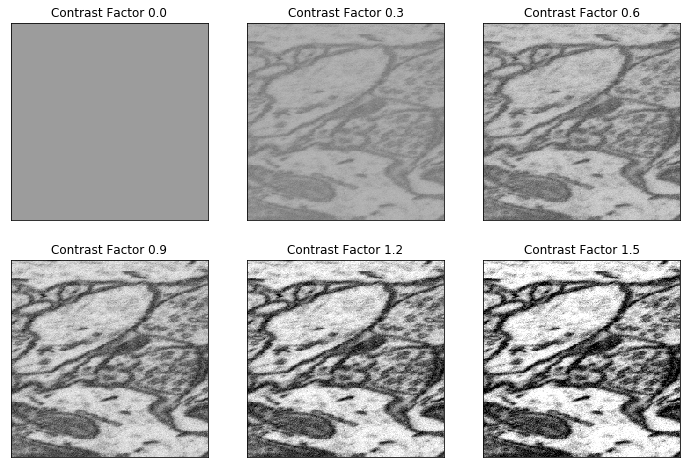

In [88]:
#plot some example images of the augmentation strengths
f, ax = plt.subplots(2, 3, figsize=(12, 8))

step = len(strengths) // 6

titles = []
examples = []
for strength, aug in zip(strengths[::step], additive_augs[::step]):
    augs = aug_cellemnet[:cn_aug_insert_loc] + [aug] + aug_cellemnet[cn_aug_insert_loc:]

    #overwrite the datasets transforms with the composed augmentations
    dataset.tfs = tf.Compose(augs)

    #get the example image by taking the:
    #zeroeth image in dataset; then its first augmented copy; then its first channel
    titles.append(f'Contrast Factor {strength:.1f}')
    examples.append(dataset[0][0][0])
    
#get maximum and minimum pixel values to use
#when plotting (otherwise pyplot rescales everything)
vmin = min([ex.min().item() for ex in examples])
vmax = max([ex.max().item() for ex in examples])
    
c = 0
for y in range(2):
    for x in range(3):
        ax[y, x].set_title(titles[c])
        ax[y, x].set_xticks([])
        ax[y, x].set_yticks([])
        ax[y, x].imshow(examples[c], cmap='gray', vmin=vmin, vmax=vmax)
        c += 1

## Scale

In [13]:
#define the augmentation strengths
#we'll do this manually here, because
#everything needs to be divisible by 32
strengths = np.array(
    [32, 64, 96, 128, 160, 192, 224, 288, 352, 416, 480, 548, 612, 704, 832, 1096, 1344]
)

#define the reference index for the augmentation.
#for scale its where strengths == 224
ref_index = np.where(strengths == 224)[0][0]

#define the list of additive augmentations
additive_augs = [tf.Resize((strength, strength)) for strength in strengths]

#where to insert the new augmentations in the augmentation
cn_aug_insert_loc = 2
in_aug_insert_loc = 2

#calculate the local trajectories for images in the dataset
cellemnet_trajectories = transform_local_trajectory(cellemnet, dataset, aug_cellemnet, additive_augs, cn_aug_insert_loc)
imagenet_trajectories = transform_local_trajectory(imagenet, dataset, aug_imagenet, additive_augs, in_aug_insert_loc)

In [14]:
#calculate the mean firing rates
cellemnet_mfr = calculate_mean_firing_rates(cellemnet_trajectories, cellemnet_thr, ref_index, 0.9)
imagenet_mfr = calculate_mean_firing_rates(imagenet_trajectories, imagenet_thr, ref_index, 0.9)

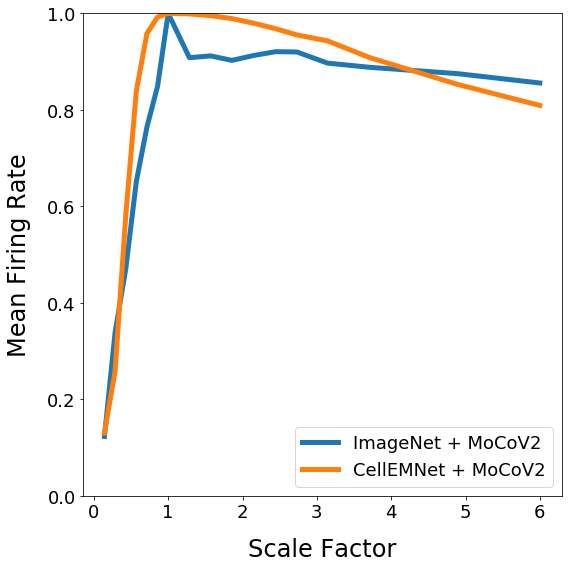

In [15]:
plt.figure(figsize=(8, 8))

#to convert from size in pixels to relative scale, divide
#all of the strengths by 224
plt.plot(strengths / 224, imagenet_mfr, linewidth=5, label='ImageNet + MoCoV2')
plt.plot(strengths / 224, cellemnet_mfr, linewidth=5, label='CellEMNet + MoCoV2')

plt.legend(loc='lower right', fontsize=18)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.ylim(bottom=0.0, top=1)
plt.xlabel('Scale Factor', fontsize=24, labelpad=16)
plt.ylabel('Mean Firing Rate', fontsize=24, labelpad=16)
plt.tight_layout()

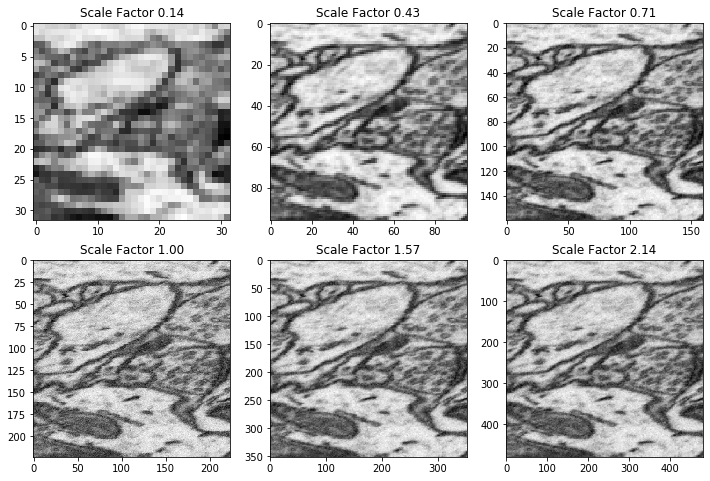

In [95]:
#plot some example images of the augmentation strengths
f, ax = plt.subplots(2, 3, figsize=(12, 8))

step = len(strengths) // 6

titles = []
examples = []
for strength, aug in zip(strengths[::step], additive_augs[::step]):
    augs = aug_cellemnet[:cn_aug_insert_loc] + [aug] + aug_cellemnet[cn_aug_insert_loc:]

    #overwrite the datasets transforms with the composed augmentations
    dataset.tfs = tf.Compose(augs)

    #get the example image by taking the:
    #zeroeth image in dataset; then its first augmented copy; then its first channel
    titles.append(f'Scale Factor {strength / 224:.2f}')
    examples.append(dataset[0][0][0])
    
c = 0
for y in range(2):
    for x in range(3):
        ax[y, x].set_title(titles[c])
        ax[y, x].imshow(examples[c], cmap='gray')
        c += 1